### Predicting Energy Consumption

In [1]:
# Import modules
import pandas as pd

In [2]:
# Load in the csv datafile
df = pd.read_csv('recs2009_public.csv')
df.head()

C:\Users\saleh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


#### Objective:

Can I build a model to predict energy consumption using the Residential Energy Consumption Survey Data?

Questions to ponder:
- What model would be the best used to attempt this?
- What features would I use from the 940 variables that exist in the data?

This is a Multivariate regression project, not classification, as I want to predict consumption amount.

#### Understanding the data

There are an incredible amount of columns, and not all will be needed to transform this data into a dataset necessary to predict energy consumption.

Alongside this jupyter notebook, I am looking at the 2009 RECS Variable and Response Codebook to understand the columns, and see which ones can be removed or bucketed together prior to further work. This will help in model selection. Understanding the data is crucial to making good choices.

In [3]:
# Basic information regarding the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Columns: 940 entries, DOEID to DesignDBT1
dtypes: float64(51), int64(884), object(5)
memory usage: 86.7+ MB


In [4]:
# NULLs?
df.columns[df.isna().any()].tolist()
df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]

Unnamed: 839    100.0
dtype: float64

In [5]:
# Drop the NULL column
df = df.drop(columns = ['Unnamed: 839'])
df

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


In [6]:
# Duplicates?
df.duplicated().sum()

0

In [7]:
# Which columns are not numeric? This information will be helpful when they're used in model building
obj_columns = list(df.select_dtypes(include=['object']).columns)
obj_columns

['METROMICRO', 'UR', 'NOCRCASH', 'NKRGALNC', 'IECC_Climate_Pub']

In [8]:
# What are the categories here?
cat_col = pd.concat([df['METROMICRO'], df['UR'], df['NOCRCASH'], df['NKRGALNC'], df['IECC_Climate_Pub']]).unique()
cat_col

array(['METRO', 'MICRO', 'NONE', 'U', 'R', -2, 1, 6, 15, 4, '-2', '1',
       '20', '.', '12', '4', '10', '3', '24', '55', '6', 8, 28, 5, 55, 3,
       16, 2, 20, 10, 24, 40, 12, 25, '15', '8', '5', '2', '77', 30, '4A',
       '3C', '5A', '6A-6B', '1A-2A', '3B-4B', '3A', '5B-5C',
       '7A-7B-7AK-8AK', '2B', '4C'], dtype=object)

The categories METROMICRO and UR intuitively feel like they can be a good source of information for the model based on the location of the household when determining energy consumption. The categories themselves can be easily LabelEncoded for the model.

NOCRCASH and NKRGALNC however, are quantitiative measurements of kerosene purchases.

In [9]:
# Check to see if this is worth keeping
df['NOCRCASH'].value_counts()

-2    9958
-2    2028
1       18
4       10
3       10
5        9
2        7
1        6
16       4
8        3
6        3
12       3
12       2
15       2
3        2
55       2
4        2
.        2
24       2
24       1
6        1
20       1
10       1
55       1
40       1
25       1
20       1
10       1
28       1
Name: NOCRCASH, dtype: int64

In [10]:
# Check to see if this is worth keeping
df['NKRGALNC'].value_counts()

-2    9958
-2    2028
5       42
3       11
1       10
10       8
10       5
5        5
1        2
15       2
.        2
15       1
20       1
30       1
2        1
2        1
8        1
3        1
77       1
8        1
55       1
Name: NKRGALNC, dtype: int64

These columns are mostly '-2' which is 'Not Applicable'. This makes the information here much less worthwhile and for the purposes of this model and time, can be dropped.

In [11]:
# Drop these two columns
df = df.drop(columns = ['NOCRCASH', 'NKRGALNC'])

In [12]:
# Check that they are dropped
df.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


In [13]:
# Check values...
df['IECC_Climate_Pub'].value_counts()

4A               2703
5A               2402
1A-2A            1740
3B-4B            1523
3A               1235
6A-6B             971
5B-5C             476
3C                368
4C                312
2B                209
7A-7B-7AK-8AK     144
Name: IECC_Climate_Pub, dtype: int64

This column's categories are more evenly spread and can serve a function if LabelEncoded.

For the sake of this assignment though and for simplicity's sake, I will remove all columns that are objects or strings so that I can avoid numerizing any category and add complexity that could complicate things later.

In [14]:
# Drop columns
df = df.drop(columns = ['METROMICRO', 'UR', 'IECC_Climate_Pub'])

The 2009 RECS Variable and Response Codebook shows that columns starting with 'Z' in the name are imputation markers.
These columns are not needed for my purposes, and I can safely remove them to simplify things.

In [15]:
# All the columns that are imputations of the variables start with a 'Z' in the column name.
df = df.loc[:, ~df.columns.str.startswith('Z')]
df

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,PERIODKR,SCALEKER,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,-2,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,-2,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,-2,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,-2,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,-2,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,-2,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,-2,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,-2,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,-2,2840,0,9010,0.54,1,53,13,93


In [16]:
# How does our dependent variable look like range wise?
print('The minimum Energy Consumption in KWH is', df['KWH'].min())
print('The maximum Energy Consumption in KWH is', df['KWH'].max())
print('The mean Energy Consumption in KWH is', df['KWH'].mean())

The minimum Energy Consumption in KWH is 17
The maximum Energy Consumption in KWH is 150254
The mean Energy Consumption in KWH is 11288.15939750062


The range of Energy consumption goes from 17 to 150254, averaging around 11288. 
<br>This is good to know when measuring the performance of Regression models because I will use different metrics to measure performance compared to classification models and their accuracy scores.
<br>I will be measuring accuracy using:
- Coefficient of Determination (R2) to determine how the model explains the variance
- Mean Absolute Error (MAE) to see how far off from the actual KWH the model predicted on average
- Root Mean Squared Error (RMSE) to see how robust it was to outliers.

In [17]:
# I've dropped some columns so reindexing would be good practice
df = df.reset_index(drop=True)

#### Model Selection

There are nearly 600 features or dependent variables in this dataset, to predict energy consumption. Many of the variables are not needed here, or are likely to be noise / not strongly related to the indepedent, KWH.
<br>Model selection is a crucial point in terms of efficiency for a Data Scientist. Each model operates differently and depending on the project or problem you are addressing, you will choose a different model. 
More complex models do not mean better solutions.

This is a 'Regression' problem. I am trying to predict 'Energy Consumption', KWH, using many features, not a 'Classification' problem.

- I can use a simple LinearRegression model, as it is simple to implement in the interests of a short assignment, less complex, and can have dimensionality reduction or feature selection techniques applied to counter its issue of over-fitting. 
<br>The con though is that it tends to over-simplify real-world problems by assuming a linear relationship among the variables, hence not recommended for practical use-cases.

- If I were to use another model, such as a DecisionTreeRegressor, or RandomForestRegressor, they intrinsicly have a 'built in' feature selection in the model, so doing this step would not be needed. 
<br>For smaller datasets, it would be good to use as it is intuitive to understand how the model works. It does not scale well though as it is computationally taxing on larger datasets, and can be a bit prone to overfitting.

- Finally, a Support Vector Regression (SVR) can be used as well. It is quite robust to outliers and has excellent generalization capabilities, but usually unsuited for large datasets and are highly susceptible to noise in the data, which this dataset seems to have present with the amount of features it has.

For the interest of this assignment, I will go with a simple LinearRegression model to keep things simple, and maybe compare it to a DecisionTreeRegressor.

#### Data Engineering

In [18]:
# Modules needed for this step
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot

In [19]:
# Feature selection function in case used
def select_features(X_train, y_train, X_test):
    # Select feature subset
    fs = SelectKBest(score_func = f_regression, k = 'all')
    # Fit to learn the relationship between them
    fs.fit(X_train, y_train)
    # Transform model input
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# Summary function for models for regressions if needed
import sklearn.metrics as metrics
def regression_results(y_test, yhat):

    # Regression metrics
    mean_absolute_error = metrics.mean_absolute_error(y_test, yhat) 
    mse = metrics.mean_squared_error(y_test, yhat) 
    median_absolute_error = metrics.median_absolute_error(y_test, yhat)
    r2 = metrics.r2_score(y_test, yhat)

    print('r2: ', round(r2, 4))
    print('MAE: ', round(mean_absolute_error, 4))
    print('MSE: ', round(mse, 4))
    print('RMSE: ', round(np.sqrt(mse), 4))

In [20]:
# Check the features alone here for anything strange
X = df.drop(columns = ['KWH'])
y = df.KWH

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\saleh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\saleh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\saleh\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value 

Feature 0: 0.092651
Feature 1: 49.061493
Feature 2: 1.060306
Feature 3: 50.946671
Feature 4: 1177.149955
Feature 5: 0.744454
Feature 6: 118.514138
Feature 7: 489.651366
Feature 8: 133.654936
Feature 9: 532.911592
Feature 10: 242.150489
Feature 11: 312.628279
Feature 12: 559.299926
Feature 13: 131.236788
Feature 14: 330.237310
Feature 15: 2.659932
Feature 16: 217.288517
Feature 17: 49.675125
Feature 18: 33.654164
Feature 19: 471.243852
Feature 20: 226.398351
Feature 21: 0.765687
Feature 22: 490.692968
Feature 23: 1072.463059
Feature 24: 1021.290965
Feature 25: 706.523636
Feature 26: 14.321944
Feature 27: 1573.838825
Feature 28: 1706.177080
Feature 29: 209.200947
Feature 30: 1174.642359
Feature 31: 1960.613453
Feature 32: 294.607905
Feature 33: 432.806437
Feature 34: 518.616780
Feature 35: 24.746346
Feature 36: 116.430340
Feature 37: 22.777181
Feature 38: 72.233867
Feature 39: 28.814610
Feature 40: 29.479302
Feature 41: 138.252676
Feature 42: 51.438267
Feature 43: 8.096282
Feature 44: 59

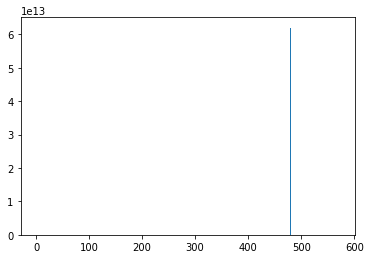

In [21]:
# what are the scores?
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [22]:
# What feature is so highly correlated?
df.iloc[:, 481]

0        63006
1        17565
2         7568
3        34171
4         9789
         ...  
12078    26092
12079     6186
12080    33554
12081    16378
12082     6018
Name: BTUEL, Length: 12083, dtype: int64

One of these features is completely washing out the others and can be skewing everything.
<br>According to the codebook for the data, this column, BTUEL, is the total site electricity usage. It will certainly be incredibly linked to total energy consumption of a residence. 
<br>Removing this and letting the others be used for training will make for a better quality model.

#### Model Pipeline

In [23]:
# Setting the target variable, which is energy consumption
X = df.drop(columns = ['KWH', 'BTUEL'])
y = df.KWH
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)
# Make pipeline to avoid data leakage between test and training sets
pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('Selector', SelectKBest()), 
    ('Estimator', LinearRegression())
    ])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
# Cross-validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# Evaluate
yhat = pipe.predict(X_test)
regression_results(y_test, yhat)
print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))
print('Cross-validated scores:', scores)

C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [360 373 390 394 449 450 451 529 533 537] are constant.
  UserWarning)
C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\saleh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


r2:  0.8865
MAE:  1818.6544
MSE:  6466713.5961
RMSE:  2542.9734
Training set score: 0.8883100068750468
Test set score: 0.88646335884791
Cross-validated scores: [-2032.02452474 -1805.13485042 -1719.92632488 -2516.08961922
 -1828.45310676 -1972.45093018 -1900.6548891  -1892.38016925
 -2095.8960592  -2159.75676381]


#### Model Results

A **Mean Absolute Error of ~1800**, and a **Coefficient of Determination (R2) of 0.88** is pretty great given the values of the dataset. You do not expect perfect models on real-world data, nor do you expect incredible results without trial and error. 
<br>Mean Squared Error being much higher is a result of squaring the error, which is in the thousands, so it can really be skewed with the scale used in KWH. which for 'Energy Consumption' ranging from the hundreds to the hundred thousands, can give staggeringly high numbers. 
<br>**The Root Mean Squared Error of 2500** is not great, but combats this.

This means that this model can account for 88% proportion of the variance in the model, which means it is actually learning. 
<br>The predictions of Energy Consumption are usually off by 1800 KWH from the actual value. When the range of KWH is between 17 and roughly 150000, is not bad for an initial pass.
<br> Furthermore, I am using MAE as the scoring method in the Cross Validation Scoring as it is the only 'absolute' metric to measure performance in regression. R2 is a relative metric, useful when comparing different models on the same data as well as general model performance.
<br> In this case, a good R2 shows that the model is learning, then I can focus on MAE to have the predictions be closer to the true values to measure how well it can work in a practical application.

This is a reasonable starting ground. I am not overfitting, or having any data leakage as I have used a pipeline to avoid this.
A GridSearch for hyperparameter optimization would be a simple way to increase performance for this model as a next step.

In [25]:
# This specific Grid returns some warnings, so I set it to ignore so it doesn't give an error out for each iteration
# I would not condone this for work-cases, I just want the assignment notebook to be as clear as possible.
import warnings
warnings.filterwarnings("ignore")

# GridSearch for hyperparameter tuning.
# I did not set a k value for SelectKBest because the default 10 should be enough, as these searches tend to choose the highest values which will cause overfitting.
parameters = {'Scaler': [StandardScaler(), Normalizer(), MinMaxScaler(), RobustScaler()],
              'Selector__k': [5, 10, 15, 20],
              'Estimator': [LinearRegression(), Ridge()]}
# Cross-validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# Instantiate
grid = GridSearchCV(pipe, parameters, cv=cv).fit(X_train, y_train)
scores = cross_val_score(grid, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# Evaluate
yhat = grid.predict(X_test)
regression_results(y_test, yhat)
print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print('Cross-validated scores:', scores)

r2:  0.9875
MAE:  469.7573
MSE:  711620.5763
RMSE:  843.5761
Training set score: 0.987668620026345
Test set score: 0.987506016958102
Cross-validated scores: [-1373.22716963  -511.04929066  -472.2050629   -463.18237426
  -498.62902175  -454.53105908  -498.41702068  -510.27649867
  -501.53102483  -465.42576845]


In [26]:
# What was the best?
best_params = grid.best_params_
print(best_params)

{'Estimator': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 'Scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True), 'Selector__k': 20}


With a GridSearch for optimization, using a different Scaler, the RobustScaler, I can reduce the effects of the outliers that made the MAE and MSE higher in the LinearRegression using StandardScaler.

The GridSearch determined that using Ridge, a form of LinearRegression with regularlization, along with a RobustScaler, performs better than a standard LinearRegression model that uses the 10 best correlated features.
The controlling of outliers has raised the **R2 to .98** and the **MAE is down to 469**, making the predictions closer to the actual values. The **RMSE is 843**, which makes it much better at dealing with outliers as well. 

Through cross-validation, this level of performance was consistent.
<br>There is likely overfitting as the results are too good, but for the sake of this assignment, this initial passthrough is thorough enough.

---

### Extra

This is an extra component to satisfy my own curiousity as to how this dataset would perform with another model.
<br> To determine whether my model selection was well reasoned, I wanted to compare it to how a RandomForestRegressor would perform.

#### How does it compare to RandomForestRegressor?

In [27]:
# Import modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [28]:
# Setting the target variable, which is energy consumption, also removing the skewing feature from the X
X = df.drop(columns = ['KWH', 'BTUEL'])
y = df.KWH

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

Let's just try a little bit of optimization first.

In [29]:
# # Tree Depth Loop
depth_values = range(1,10)
train_acc = []
test_acc = []

for d in depth_values:
    # Instantiate model
    dtr = RandomForestRegressor(max_depth=d)

    # Fit model
    dtr.fit(X_train, y_train)

    # Score / Accuracy of model
    train = dtr.score(X_train,y_train)
    test = dtr.score(X_test,y_test)
    
    # Append list
    train_acc.append(train)
    test_acc.append(test)

In [30]:
# Min Samples at Leaf Loop
leaf = range(1, 40)
train_acc2 = []
test_acc2 = []

for l in leaf:
    # Instantiate model
    dtr = RandomForestRegressor(min_samples_leaf=l)

    # Fit model
    dtr.fit(X_train, y_train)

    # Score / Accuracy of model
    train = dtr.score(X_train,y_train)
    test = dtr.score(X_test,y_test)
    
    # Append list
    train_acc2.append(train)
    test_acc2.append(test)

In [31]:
# Estimators
estimators = range(100, 500, 100)
train_acc3 = []
test_acc3 = []

for e in estimators:
    # Instantiate model
    dtr = RandomForestRegressor(n_estimators=e)

    # Fit model
    dtr.fit(X_train, y_train)

    # Score / Accuracy of model
    train = dtr.score(X_train,y_train)
    test = dtr.score(X_test,y_test)
    
    # Append list
    train_acc3.append(train)
    test_acc3.append(test)

<function matplotlib.pyplot.show(*args, **kw)>

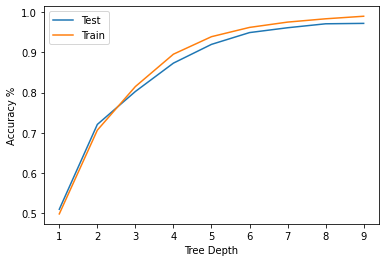

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot tree depth
plt.figure()
plt.plot(depth_values, test_acc, label='Test')
plt.plot(depth_values, train_acc, label='Train')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy %')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

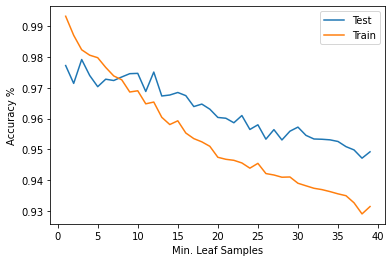

In [33]:
# Plot of leaf samples
plt.figure()
plt.plot(leaf, test_acc2, label='Test')
plt.plot(leaf, train_acc2, label='Train')
plt.xlabel('Min. Leaf Samples')
plt.ylabel('Accuracy %')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

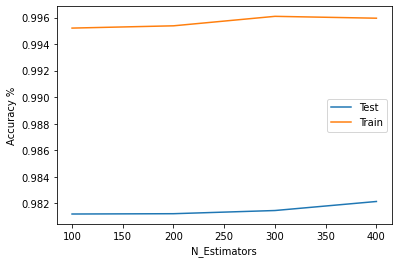

In [34]:
# Plot of n_estimators
plt.figure()
plt.plot(estimators, test_acc3, label='Test')
plt.plot(estimators, train_acc3, label='Train')
plt.xlabel('N_Estimators')
plt.ylabel('Accuracy %')
plt.legend()
plt.show

Now, a quick glance at the graphs can show how each hyperparameter affects the performance of the model.

- Tree Depth goes flat after 3, which is to be expected.
- There are a lot of features in the dataset, so a higher minimum leaf samples value will fit the data better and reduce overfitting.
- The number of estimators influences performance but tends to be more gradual.

In [35]:
# How does it work all together?
X = df.drop(columns = ['KWH', 'BTUEL'])
y = df.KWH

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

# Instantiate
dtr = RandomForestRegressor(max_depth=3, min_samples_leaf=30, n_estimators=200)
dtr.fit(X_train, y_train)
yhat = dtr.predict(X_test)
regression_results(y_test, yhat)

r2:  0.8223
MAE:  2243.9884
MSE:  10122257.0739
RMSE:  3181.5495


The RandomForestRegressor performed a little more poorly compared to the LinearRegression model, and also it was executed more slowly than the LinearRegression.

---

#### Final Thoughts

Using the data acquired from the RESIDENTIAL ENERGY CONSUMPTION SURVEY (RECS), I was tasked with building a model to predict Energy Consumption (KWH).
<br>Through reading the data dictionary and some light exploration of the data, I was able to find some outliers, and the best features in the dataset.

A simple LinearRegression using a StandardScaler to standardize the data, the 10 best correlated features, and cross-validation techniques focused on reducing the mean absolute error, gave a reasonable starting ground.
- **Mean Absolute Error of ~1818**
- **Coefficient of Determination (R2) of 0.88** 
- **The Root Mean Squared Error of 2542**
- Seems to be a more realistic model for the data

Using Cross-Validation techniques, controlling for outliers, as well as a simple ETL Pipeline, I created a GridSearch to find the best hyperparameters for a simple Ridge (LinearRegression with Regularlization) model which was able to account for:
- **98% of the variance in the data accounted for (R2 = 0.98)**
- **Mean Absolute Error of 469**
- **Root Mean Squared Error of 843**
- It was also robust toward outliers, which is a great first passthrough.
- Could be overfitting still

I attempted a different mode, the RandomForestRegressor to compare results and to solidify my inital model choice.
<br> The RandomForestRegressor executed more slowly, and performed less well as the simple LinearRegression model in every metric.